# Project2: Data Representations and Clustering
-   505851728 Yang-Shan Chen
-   005627440 Chih-En Lin
-   505297814 Rikako Hatoya

In [ ]:
import hdbscan
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import umap
import umap.plot
import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import rand_score
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

import warnings
warnings.filterwarnings('ignore')

import random
np.random.seed(0)
random.seed(0)

# Question 1

In [ ]:
class1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

dataset = fetch_20newsgroups(subset='all', categories=class1+class2, shuffle=True, random_state=0, remove=('headers', 'footers'))

In [ ]:
data_labels = []

for label in dataset.target:
    if 0 <= label and label <= 3:
        data_labels.append(0)
    elif 4 <= label and label <= 7:
        data_labels.append(1)

In [ ]:
tfidf_transformer = TfidfTransformer()
vectorizer = CountVectorizer(min_df=3, stop_words='english')

data_count = vectorizer.fit_transform(dataset.data)
data_tfidf = tfidf_transformer.fit_transform(data_count).toarray()

print("The shape of the TF-IDF matrix is {}".format(data_tfidf.shape))

The shape of the TF-IDF matrix is (7882, 23522)


# Question 2

In [ ]:
#===plotmat.py===
import itertools
def plot_mat(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None, title = None, vmin=None, vmax=None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)
    
    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.1)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if xticklabels is None:
        xticklabels = [str(i) for i in xticks]
    if yticklabels is None:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # Minor ticks
    # ax.set_xticks(xticks, minor=True);
    # ax.set_yticks(yticks, minor=True);
    # ax.set_xticklabels([], minor=True)
    # ax.set_yticklabels([], minor=True)

    # ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = False)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)
    if title:
        plt.title(title, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%d", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=10)

    if if_show_values:
        show_values(im)
    # for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    #     ax.text(j, i, "{:.2f}".format(mat[i, j]), fontsize = 4,
    #              horizontalalignment="center",
    #              color="white" if mat[i, j] > thresh else "black")

    plt.tight_layout()
    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)
    plt.show()
    plt.close()

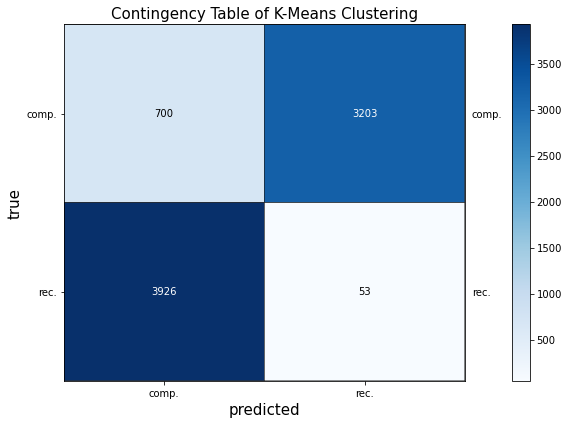

In [ ]:
# random_state=0, max_iter>=1000, n_init>=30, n_init=200 would be better
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=200).fit(data_tfidf)
plot_mat(contingency_matrix(data_labels, kmeans.labels_), size=(8, 6), xticklabels=['comp.', 'rec.'], yticklabels=['comp.', 'rec.'], xlabel='predicted', ylabel='true', title='Contingency Table of K-Means Clustering')


From the plot above, the contingency matrix is square-shaped. However, it doesn't have to be square-shaped. For example, if we set KMeans(n_clusters=3, ...), the contingency matrix will not be square. And, another example is using "hdbscan", we can't expect how many clusters we will get. Thus, the contingency matrix we construct may not be square.

# Question 3

In [ ]:
def clustering_metrics(labels_true, labels_pred):
    print("Homogeneity Score: ", homogeneity_score(labels_true, labels_pred))
    print("Completeness Score: ", completeness_score(labels_true, labels_pred))
    print("V_measure Score: ", v_measure_score(labels_true, labels_pred, beta=1.0))
    print("Adjusted Rand Score: ", adjusted_rand_score(labels_true, labels_pred))
    print("Adjusted Mutual Info Score: ", adjusted_mutual_info_score(labels_true, labels_pred, average_method='arithmetic'))
    print("Rand Score: ", rand_score(labels_true, labels_pred))
    return

In [ ]:
clustering_metrics(data_labels, kmeans.labels_)

Homogeneity Score:  0.5905524257932604
Completeness Score:  0.6037369950642207
V_measure Score:  0.5970719337366653
Adjusted Rand Score:  0.6543270617544648
Adjusted Mutual Info Score:  0.5970346379937653
Rand Score:  0.8271633545693536


# Question 4

In [ ]:
svd = TruncatedSVD(n_components=1000, random_state=0)
svd_ft = svd.fit_transform(data_tfidf)
retained_ratio = np.cumsum(svd.explained_variance_ratio_)

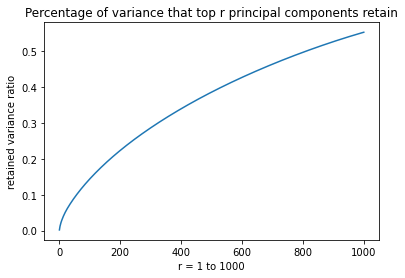

In [ ]:
plt.plot(np.linspace(1, 1000, num=1000), retained_ratio)
plt.xlabel('r = 1 to 1000')
plt.ylabel('retained variance ratio')
plt.title('Percentage of variance that top r principal components retain')
plt.show()

# Question 5

In [ ]:
scores_svd = {}
scores_nmf = {}

scores_svd['h'] = []
scores_svd['c'] = []
scores_svd['v'] = []
scores_svd['ari'] = []
scores_svd['ami'] = []

scores_nmf['h'] = []
scores_nmf['c'] = []
scores_nmf['v'] = []
scores_nmf['ari'] = []
scores_nmf['ami'] = []

rs = [1, 2, 3, 5, 10, 20, 50, 100, 300]
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=200)

for r in rs:
    print("SVD with r = {} ... ".format(r), end = '')
    svd = TruncatedSVD(n_components=r, random_state=0)
    svd_ft = svd.fit_transform(data_tfidf) 
    kmeans_svd = kmeans.fit(svd_ft)

    scores_svd['h'].append(homogeneity_score(data_labels, kmeans_svd.labels_))
    scores_svd['c'].append(completeness_score(data_labels, kmeans_svd.labels_))
    scores_svd['v'].append(v_measure_score(data_labels, kmeans_svd.labels_))
    scores_svd['ari'].append(adjusted_rand_score(data_labels, kmeans_svd.labels_))
    scores_svd['ami'].append(adjusted_mutual_info_score(data_labels, kmeans_svd.labels_))
    
    print("Done")

print("")
for r in rs:
    print("NMF with r = {} ... ".format(r), end = '')
    nmf = NMF(n_components=r, random_state=0, init='random', max_iter=300)
    nmf_ft = nmf.fit_transform(data_tfidf) 
    kmeans_nmf = kmeans.fit(nmf_ft)
    
    scores_nmf['h'].append(homogeneity_score(data_labels, kmeans_nmf.labels_))
    scores_nmf['c'].append(completeness_score(data_labels, kmeans_nmf.labels_))
    scores_nmf['v'].append(v_measure_score(data_labels, kmeans_nmf.labels_))
    scores_nmf['ari'].append(adjusted_rand_score(data_labels, kmeans_nmf.labels_))
    scores_nmf['ami'].append(adjusted_mutual_info_score(data_labels, kmeans_nmf.labels_))
    
    print("Done")

print("\nAll Done.")

SVD with r = 1 ... Done
SVD with r = 2 ... Done
SVD with r = 3 ... Done
SVD with r = 5 ... Done
SVD with r = 10 ... Done
SVD with r = 20 ... Done
SVD with r = 50 ... Done
SVD with r = 100 ... Done
SVD with r = 300 ... Done

NMF with r = 1 ... Done
NMF with r = 2 ... Done
NMF with r = 3 ... Done
NMF with r = 5 ... Done
NMF with r = 10 ... Done
NMF with r = 20 ... Done
NMF with r = 50 ... Done
NMF with r = 100 ... Done
NMF with r = 300 ... Done

All Done.


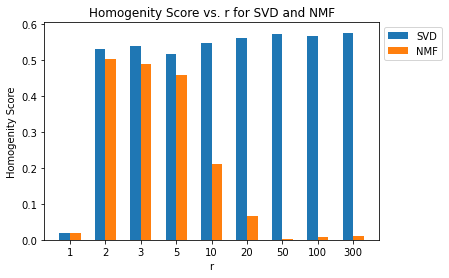

r =   1, SVD: 0.01914  NMF: 0.01914
r =   2, SVD: 0.53061  NMF: 0.50225
r =   3, SVD: 0.53777  NMF: 0.48822
r =   5, SVD: 0.51659  NMF: 0.45739
r =  10, SVD: 0.54609  NMF: 0.21021
r =  20, SVD: 0.56097  NMF: 0.06529
r =  50, SVD: 0.57250  NMF: 0.00213
r = 100, SVD: 0.56698  NMF: 0.00750
r = 300, SVD: 0.57525  NMF: 0.01102


In [ ]:
width = 0.3
plt.bar(np.arange(len(rs)), scores_svd['h'], width, label='SVD')
plt.bar(np.arange(len(rs)) + width, scores_nmf['h'], width, label='NMF')
plt.xticks(np.arange(len(rs)) + width/2, rs)
plt.xlabel('r')
plt.ylabel('Homogenity Score')
plt.title('Homogenity Score vs. r for SVD and NMF')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

for i in np.arange(len(rs)):
    print("r = {:3d}, SVD: {:.5f}  NMF: {:.5f}".format(rs[i], scores_svd['h'][i], scores_nmf['h'][i]))

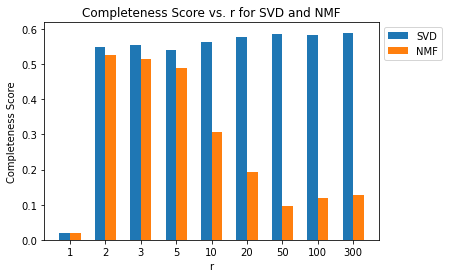

r =   1, SVD: 0.01945  NMF: 0.01945
r =   2, SVD: 0.54803  NMF: 0.52638
r =   3, SVD: 0.55428  NMF: 0.51349
r =   5, SVD: 0.53959  NMF: 0.49016
r =  10, SVD: 0.56295  NMF: 0.30644
r =  20, SVD: 0.57722  NMF: 0.19318
r =  50, SVD: 0.58691  NMF: 0.09591
r = 100, SVD: 0.58220  NMF: 0.11960
r = 300, SVD: 0.58965  NMF: 0.12823


In [ ]:
plt.bar(np.arange(len(rs)), scores_svd['c'], width, label='SVD')
plt.bar(np.arange(len(rs)) + width, scores_nmf['c'], width, label='NMF')
plt.xticks(np.arange(len(rs)) + width/2, rs)
plt.xlabel('r')
plt.ylabel('Completeness Score')
plt.title('Completeness Score vs. r for SVD and NMF')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

for i in np.arange(len(rs)):
    print("r = {:3d}, SVD: {:.5f}  NMF: {:.5f}".format(rs[i], scores_svd['c'][i], scores_nmf['c'][i]))

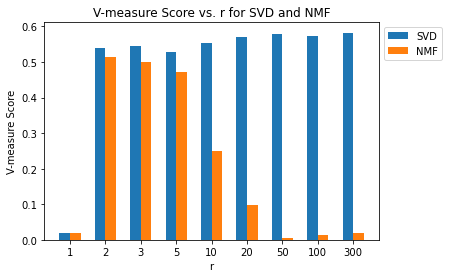

r =   1, SVD: 0.01929  NMF: 0.01929
r =   2, SVD: 0.53918  NMF: 0.51403
r =   3, SVD: 0.54590  NMF: 0.50054
r =   5, SVD: 0.52784  NMF: 0.47321
r =  10, SVD: 0.55439  NMF: 0.24936
r =  20, SVD: 0.56898  NMF: 0.09760
r =  50, SVD: 0.57962  NMF: 0.00417
r = 100, SVD: 0.57449  NMF: 0.01412
r = 300, SVD: 0.58236  NMF: 0.02030


In [ ]:
plt.bar(np.arange(len(rs)), scores_svd['v'], width, label='SVD')
plt.bar(np.arange(len(rs)) + width, scores_nmf['v'], width, label='NMF')
plt.xticks(np.arange(len(rs)) + width/2, rs)
plt.xlabel('r')
plt.ylabel('V-measure Score')
plt.title('V-measure Score vs. r for SVD and NMF')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

for i in np.arange(len(rs)):
    print("r = {:3d}, SVD: {:.5f}  NMF: {:.5f}".format(rs[i], scores_svd['v'][i], scores_nmf['v'][i]))

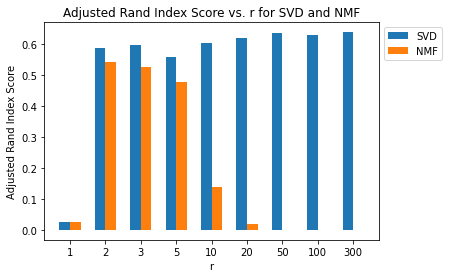

r =   1, SVD: 0.02617  NMF: 0.02617
r =   2, SVD: 0.58717  NMF: 0.54068
r =   3, SVD: 0.59654  NMF: 0.52475
r =   5, SVD: 0.55684  NMF: 0.47558
r =  10, SVD: 0.60283  NMF: 0.13903
r =  20, SVD: 0.61790  NMF: 0.01799
r =  50, SVD: 0.63436  NMF: -0.00006
r = 100, SVD: 0.62671  NMF: 0.00050
r = 300, SVD: 0.63679  NMF: 0.00088


In [ ]:
plt.bar(np.arange(len(rs)), scores_svd['ari'], width, label='SVD')
plt.bar(np.arange(len(rs)) + width, scores_nmf['ari'], width, label='NMF')
plt.xticks(np.arange(len(rs)) + width/2, rs)
plt.xlabel('r')
plt.ylabel('Adjusted Rand Index Score')
plt.title('Adjusted Rand Index Score vs. r for SVD and NMF')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

for i in np.arange(len(rs)):
    print("r = {:3d}, SVD: {:.5f}  NMF: {:.5f}".format(rs[i], scores_svd['ari'][i], scores_nmf['ari'][i]))

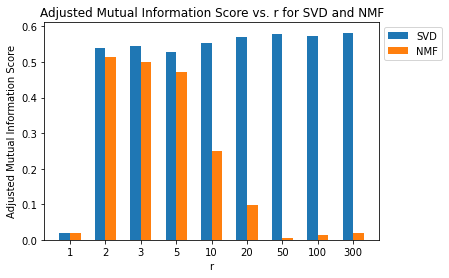

r =   1, SVD: 0.01920  NMF: 0.01920
r =   2, SVD: 0.53913  NMF: 0.51399
r =   3, SVD: 0.54585  NMF: 0.50049
r =   5, SVD: 0.52780  NMF: 0.47316
r =  10, SVD: 0.55435  NMF: 0.24928
r =  20, SVD: 0.56894  NMF: 0.09748
r =  50, SVD: 0.57958  NMF: 0.00398
r = 100, SVD: 0.57445  NMF: 0.01395
r = 300, SVD: 0.58233  NMF: 0.02013


In [ ]:
plt.bar(np.arange(len(rs)), scores_svd['ami'], width, label='SVD')
plt.bar(np.arange(len(rs)) + width, scores_nmf['ami'], width, label='NMF')
plt.xticks(np.arange(len(rs)) + width/2, rs)
plt.xlabel('r')
plt.ylabel('Adjusted Mutual Information Score')
plt.title('Adjusted Mutual Information Score vs. r for SVD and NMF')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

for i in np.arange(len(rs)):
    print("r = {:3d}, SVD: {:.5f}  NMF: {:.5f}".format(rs[i], scores_svd['ami'][i], scores_nmf['ami'][i]))

In [ ]:
# Calculate average scores of 5 measure scores
scores_svd['avg'] = []
scores_nmf['avg'] = []

for i in np.arange(len(rs)):
    scores_svd['avg'].append((scores_svd['h'][i] + scores_svd['c'][i] + scores_svd['v'][i] + scores_svd['ari'][i] + scores_svd['ami'][i]) / 5)
    scores_nmf['avg'].append((scores_nmf['h'][i] + scores_nmf['c'][i] + scores_nmf['v'][i] + scores_nmf['ari'][i] + scores_nmf['ami'][i]) / 5)
       

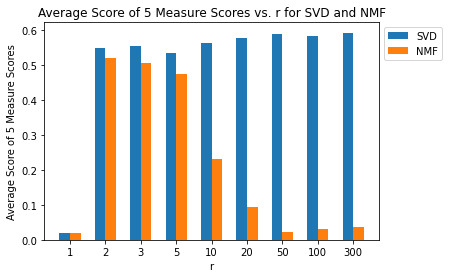

r =   1, SVD: 0.02065  NMF: 0.02065
r =   2, SVD: 0.54882  NMF: 0.51947
r =   3, SVD: 0.55607  NMF: 0.50550
r =   5, SVD: 0.53373  NMF: 0.47390
r =  10, SVD: 0.56412  NMF: 0.23086
r =  20, SVD: 0.57880  NMF: 0.09431
r =  50, SVD: 0.59060  NMF: 0.02123
r = 100, SVD: 0.58496  NMF: 0.03113
r = 300, SVD: 0.59328  NMF: 0.03611


In [ ]:
plt.bar(np.arange(len(rs)), scores_svd['avg'], width, label='SVD')
plt.bar(np.arange(len(rs)) + width, scores_nmf['avg'], width, label='NMF')
plt.xticks(np.arange(len(rs)) + width/2, rs)
plt.xlabel('r')
plt.ylabel('Average Score of 5 Measure Scores')
plt.title('Average Score of 5 Measure Scores vs. r for SVD and NMF')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

for i in np.arange(len(rs)):
    print("r = {:3d}, SVD: {:.5f}  NMF: {:.5f}".format(rs[i], scores_svd['avg'][i], scores_nmf['avg'][i]))

- The possible values of r are 1, 2, 3, 5, 10, 20, 50, 100, 300. From the five plots of 5 different measure scores. we can see the relationship of scores and various r.
- In order to choose the best r for SVD and NMF respectively, we average the 5 different measure scores to become one score (the last plot above).
- We can discover that for SVD, the best r is 50 because the avg. scores doesn't increase much after r = 50, and Kmeans doesn't perform well in high dimensions. Considering the information preservation and better performance of Kmeans in lower dimensions, the best r for SVD is 50.
- We can obviously discover that for NMF, the best r is 2.

# Question 6

- For SVD, we can see that with r increaces, the score basically increase, but it is disproportionate and coverages at about 0.59. If r is getting large, the amount of semantic and complex information in the data for clustering increases. Theoretically, we should get better clustering performance. However, Kmeans doesn't perform well in high dimensions because the Euclidean distance is not a good metric anymore. It causes the distances coverage to a constant value between data points and tends to be almost the same.
- For NMF, the score initially increases very high at r = 2 and then decreases sharply. This is because NMF only allows positive entries in the reduced-rank feature matrix. Therefore, in higher dimensions (when r is large), SVD has better performance than NMF.

# Question 7

Compared to the scores in Question 3, the scores on average at the best choice r are a little bit lower. (Q3: 0.60, Q5/SVD: 0.59, Q5/NMF: 0.52). The reasons why we don't get better results are discussed in the above question. It is about the trade-off between the information preservation and better performance of Kmeans in lower dimensions.

# Question 8

- Best r for SVD = 50
- Best r for NMF = 2

We plotted the first two principal components of the feature matrix of SVD and NMF.

In [ ]:
# Best r for SVD = 50
# Best r for NMF = 2

kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=200)

svd = TruncatedSVD(n_components=50, random_state=0)
svd_ft = svd.fit_transform(data_tfidf)
svd_labels = kmeans.fit_predict(svd_ft)

nmf = NMF(n_components=2, random_state=0, init='random', max_iter=300)
nmf_ft = nmf.fit_transform(data_tfidf)
nmf_labels = kmeans.fit_predict(nmf_ft)

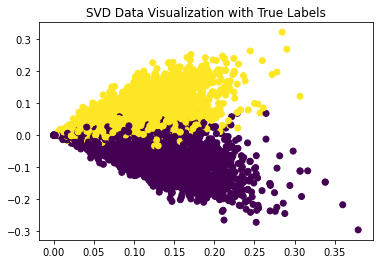

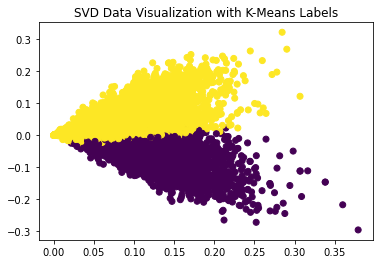

In [ ]:
plt.scatter(svd_ft[:, 0], svd_ft[:, 1], c = data_labels)
plt.title("SVD Data Visualization with True Labels")
plt.show()

plt.scatter(svd_ft[:, 0], svd_ft[:, 1], c = svd_labels)
plt.title("SVD Data Visualization with K-Means Labels")
plt.show()

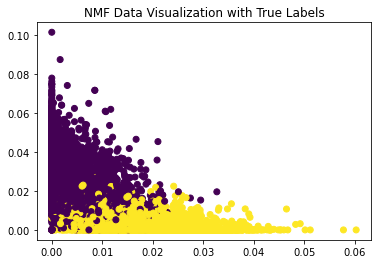

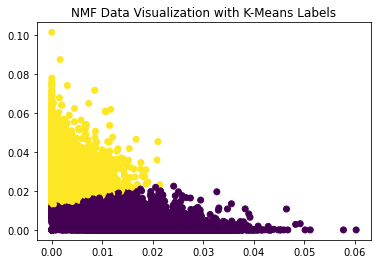

In [ ]:
plt.scatter(nmf_ft[:, 0], nmf_ft[:, 1], c = data_labels)
plt.title("NMF Data Visualization with True Labels")
plt.show()

plt.scatter(nmf_ft[:, 0], nmf_ft[:, 1], c = nmf_labels)
plt.title("NMF Data Visualization with K-Means Labels")
plt.show()

# Question 9

- For both SVD and NMF, the distributions are not spherical on the plots. K-means assumes the clusters are convex, but the two plots are irregularly shaped, especially for NMF, the two classes have different shape.
- For both SVD and NMF, we can observe that there is a significant overlap among the two clusters, and there is no definite decision boundary between the two clusters. 
- Kmeans assumes the clusters will be univariant. However, as the two plots shown, the variances are not equal for two clusters.
- Based on the above observations, the distributions of the data label for Kmeans clustering are not ideal.

# Question 10

In [ ]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

#Remove stopwords
stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en), set(punctuation), set(stop_words_skt))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

def remove_stopwords(data):
    wordlist=[]
    for word in nltk.word_tokenize(data):
        word=word.lower()
        if (word in english_vocab) and word.isalpha() and ((word in combined_stopwords) == False):
            wordlist.append(word)
    return wordlist

In [ ]:
#TF-IDF Construction
dataset_all = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, remove=('headers', 'footers'))
cleaned_data_all_text=[]
for data in dataset_all.data:
    cleaned_data_all_text.append(' '.join(remove_stopwords(data)))

tfidf_transformer=TfidfTransformer()
vectorizer=CountVectorizer(min_df=3)

data_all_count = vectorizer.fit_transform(cleaned_data_all_text)
data_all_tfidf = tfidf_transformer.fit_transform(data_all_count).toarray()

print("The shape of the TF-IDF matrix is {}".format(data_all_tfidf.shape))

The shape of the TF-IDF matrix is (18846, 16332)


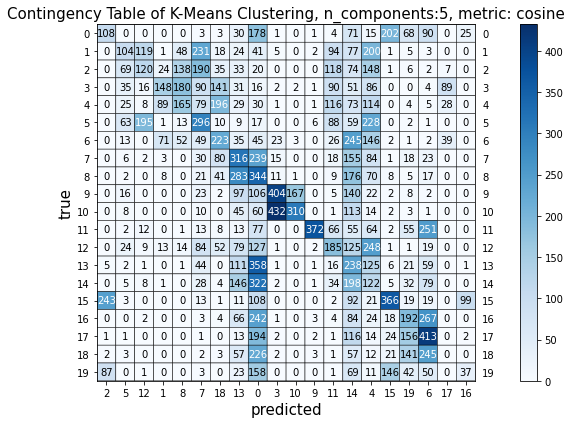

Homogeneity Score:  0.27948135941481755
Completeness Score:  0.3046329140008767
V_measure Score:  0.2915156324792342
Rand Score:  0.8911547188116486
Adjusted Rand Score:  0.0982048006382202
Adjusted Mutual Info Score:  0.28912264821974515


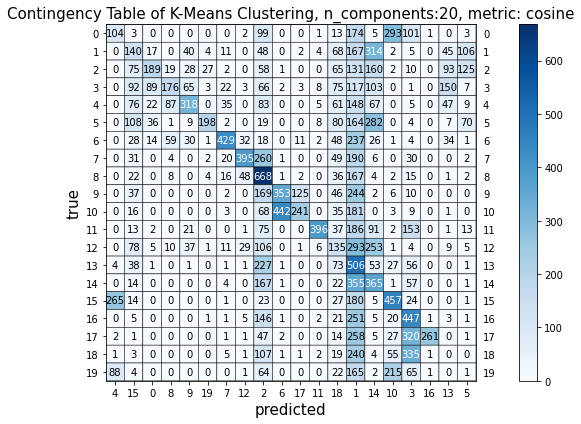

Homogeneity Score:  0.30930764379919023
Completeness Score:  0.3534246650819356
V_measure Score:  0.3298977549519759
Rand Score:  0.8718242823153872
Adjusted Rand Score:  0.10481224693436049
Adjusted Mutual Info Score:  0.32758369956663563


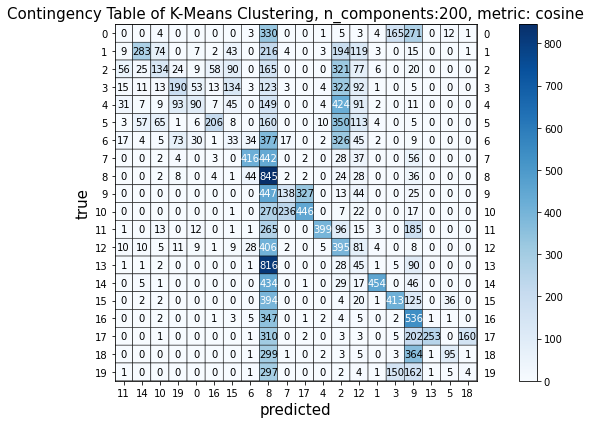

Homogeneity Score:  0.30012705622977626
Completeness Score:  0.3969413975367476
V_measure Score:  0.3418110588557484
Rand Score:  0.8005061989221712
Adjusted Rand Score:  0.07586998694565665
Adjusted Mutual Info Score:  0.33937344012320975


In [ ]:
# Dimension Reduction: SVD
n_components=[5,20,200]

for component in n_components:
  embedding=TruncatedSVD(n_components=component, random_state=42).fit_transform(data_all_tfidf)
  kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=200).fit(embedding)
  cm = confusion_matrix(dataset_all.target, kmeans.labels_)
  rows, cols = linear_sum_assignment(cm, maximize=True)
  plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,6), xlabel='predicted', ylabel='true', title='Contingency Table of K-Means Clustering (n_clusters=20) with SVD (n_components:'+str(component)+')')
  clustering_metrics(dataset_all.target, kmeans.labels_)

# Question 11

In [ ]:
#Defining UMAP reduction
def umap_reduction(data, target, n_components, metric):
  map = umap.UMAP(n_components=n_components, random_state=0, metric=metric)
  embedding = map.fit_transform(data)
  plt.scatter(embedding[:, 0], embedding[:, 1], s= 5, c=target, cmap='Spectral')
  plt.title('UMAP Embedding, n_components='+str(n_components), fontsize=24)
  plt.show()
  return embedding

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


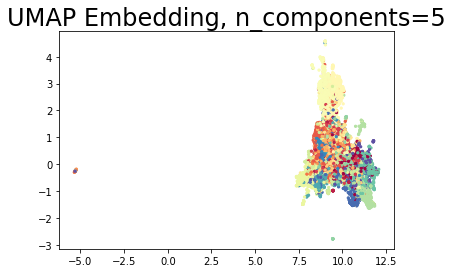

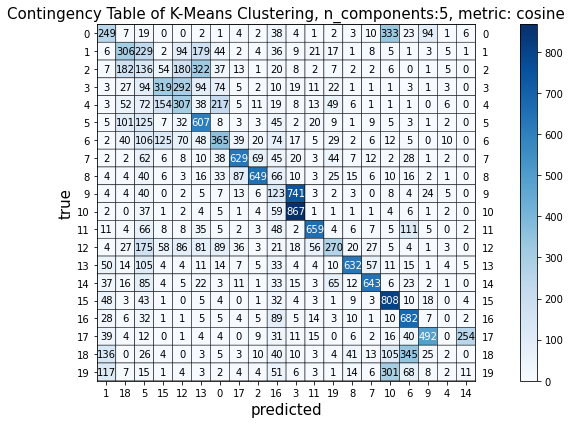

Homogeneity Score:  0.447085619390336
Completeness Score:  0.464107393138403
V_measure Score:  0.4554375164688232
Rand Score:  0.9278027064796069
Adjusted Rand Score:  0.30991663689219257
Adjusted Mutual Info Score:  0.4536365366724623


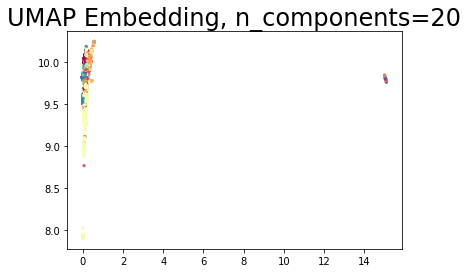

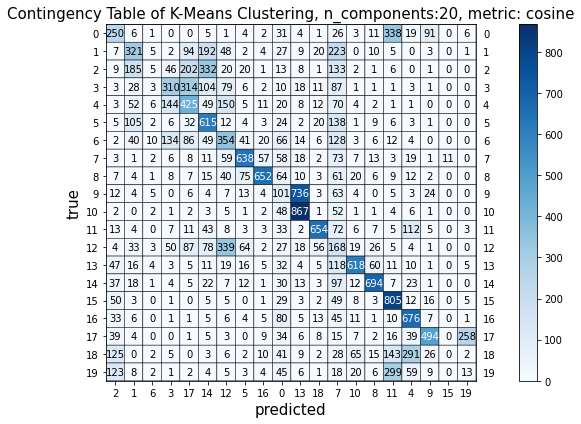

Homogeneity Score:  0.44509986552729197
Completeness Score:  0.47014668361819834
V_measure Score:  0.45728055648379706
Rand Score:  0.9256836922083721
Adjusted Rand Score:  0.3075492158267226
Adjusted Mutual Info Score:  0.45546581554186527


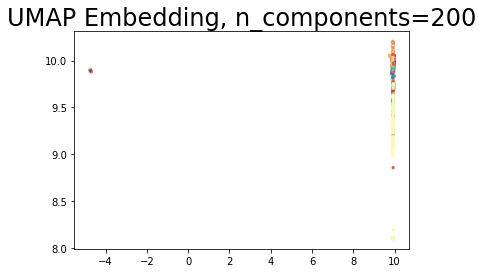

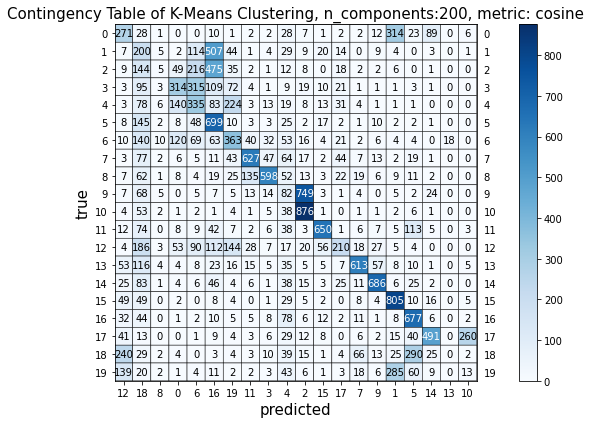

Homogeneity Score:  0.44459038442790794
Completeness Score:  0.47451675194112813
V_measure Score:  0.4590663630279601
Rand Score:  0.922751377456136
Adjusted Rand Score:  0.3033879521637711
Adjusted Mutual Info Score:  0.4572388848655579


In [ ]:
#UMAP: Cosine
n_components=[5,20,200]

for component in n_components:
  embedding=umap_reduction(data_all_tfidf, dataset_all.target, component, 'cosine')
  kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=200).fit(embedding)
  cm = confusion_matrix(dataset_all.target, kmeans.labels_)
  rows, cols = linear_sum_assignment(cm, maximize=True)
  plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,6), xlabel='predicted', ylabel='true', title='Contingency Table of K-Means Clustering, n_components:'+str(component)+', metric: cosine')
  clustering_metrics(dataset_all.target, kmeans.labels_)

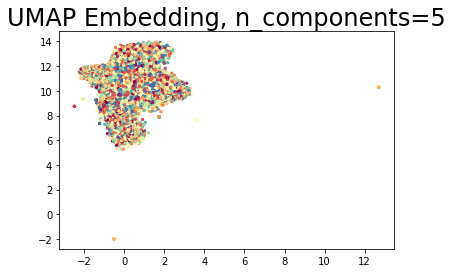

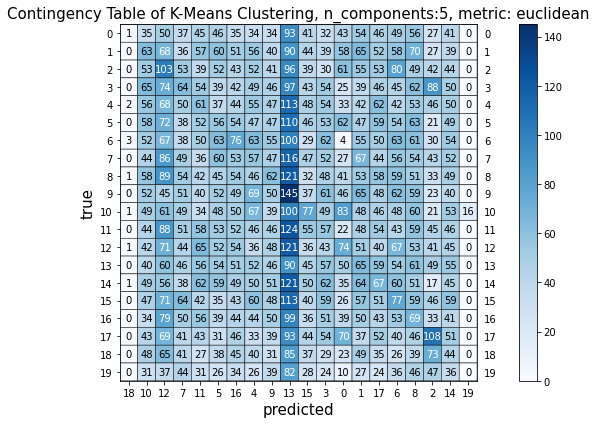

Homogeneity Score:  0.008973314227851121
Completeness Score:  0.009357410268626786
V_measure Score:  0.009161338136465087
Rand Score:  0.8962586392727165
Adjusted Rand Score:  0.0014852038169070893
Adjusted Mutual Info Score:  0.005871041921772191


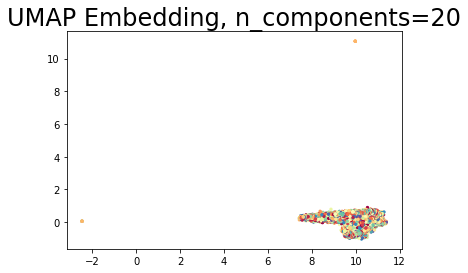

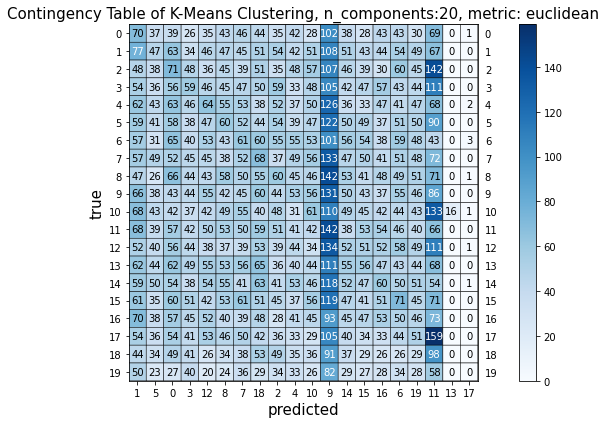

Homogeneity Score:  0.006114005577377522
Completeness Score:  0.006416903541044682
V_measure Score:  0.006261793724409466
Rand Score:  0.89392734458263
Adjusted Rand Score:  0.0010454463473835898
Adjusted Mutual Info Score:  0.002951123364435492


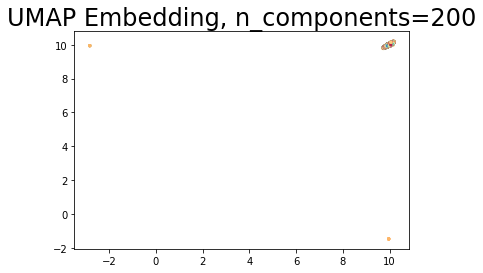

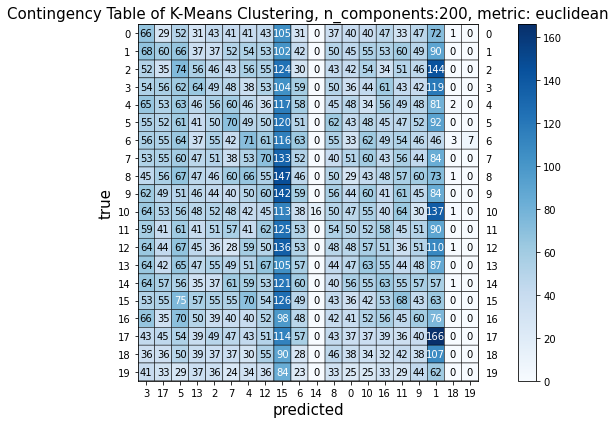

Homogeneity Score:  0.00650516045327881
Completeness Score:  0.006957281556622199
V_measure Score:  0.006723629013395848
Rand Score:  0.8909627507726462
Adjusted Rand Score:  0.001075404452374812
Adjusted Mutual Info Score:  0.0033997930972916993


In [ ]:
#UMAP: Euclidean
for component in n_components:
  embedding=umap_reduction(data_all_tfidf, dataset_all.target, component, 'euclidean')
  kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=200).fit(embedding)
  cm = confusion_matrix(dataset_all.target, kmeans.labels_)
  rows, cols = linear_sum_assignment(cm, maximize=True)
  plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,6), xlabel='predicted', ylabel='true', title='Contingency Table of K-Means Clustering, n_components:'+str(component)+', metric: euclidean')
  clustering_metrics(dataset_all.target, kmeans.labels_)

# Question 12

UMAP reduced data with n_components=5 and k-means clustering with n_clusters=20 achieves its highest adjusted rand index for both the cosine metric and the euclidean metric (0.30991663689219257 and 0.0014852038169070893). However, this rand index is significantly higher with the cosine metric as we are dealing with text data, which doesn't rely on the lengths of each document and cosine distance is also invariant to the scalings of signals. The contingency matrix for euclidean measurements is also observed with 1 major cluster label with other points dispersed over the total 18 labels for n_components=5 as where for n_components=20, 2 major cluster labels are observed with 18 in total, and for n_components=200, 2 major cluster labels with 17 in total. The diagonal line as observed with the cosine data contingency matrices are not observed with euclidean data which indicates that the accuracies of the clustering labels compared to the target labels are much higher than that of cosine data.

# Question 13

So far, k-Means was applied to data dimensionally reduced by UMAP, SVD, NMF indicating them to have the highest adjusted rand index (thus, accuracy in the cluster labels) in this order with UMAP creating significantly better results. Furthermore, the contingency matrix for UMAP reduced data is evenly dispersed amongst the created cluster labels with a majority of them successfully located on the diagonal, indicating that they match the labels of the target data.

# Question 14

In [ ]:
#Generating UMAP reduced data
umap_reduced=umap_reduction(data_all_tfidf, dataset_all.target, 5, 'cosine')

In [ ]:
#Agglomerative Clustering, Linkage: None
model = AgglomerativeClustering(affinity='euclidean', n_clusters=20)
model=model.fit(umap_reduced)
print("Clustering Metrics for Agglomerative Clustering, Linkage: None")
clustering_metrics(dataset_all.target, model.labels_)

Clustering Metrics for Agglomerative Clustering, Linkage: None
Homogeneity Score:  0.43279752892488915
Completeness Score:  0.4638727880186545
V_measure Score:  0.44779668200528394
Rand Score:  0.9207073562435241
Adjusted Rand Score:  0.29077162437827136
Adjusted Mutual Info Score:  0.44592687704998557
None


In [ ]:
#Agglomerative Clustering, Linkage: Ward
model_ward = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=20)
model_ward=model_ward.fit(umap_reduced)
print("Clustering Metrics for Agglomerative Clustering, Linkage: Ward")
clustering_metrics(dataset_all.target, model_ward.labels_)

Clustering Metrics for Agglomerative Clustering, Linkage: Ward
Homogeneity Score:  0.43279752892488915
Completeness Score:  0.4638727880186545
V_measure Score:  0.44779668200528394
Rand Score:  0.9207073562435241
Adjusted Rand Score:  0.29077162437827136
Adjusted Mutual Info Score:  0.44592687704998557


In [ ]:
#Agglomerative Clustering, Linkage: Single
model_single = AgglomerativeClustering(affinity='euclidean', linkage='single', n_clusters=20)
model_single=model_single.fit(umap_reduced)
print("Clustering Metrics for Agglomerative Clustering, Linkage: Single")
clustering_metrics(dataset_all.target, model_single.labels_)

Clustering Metrics for Agglomerative Clustering, Linkage: Single
Homogeneity Score:  0.013598525247829195
Completeness Score:  0.2777544298099884
V_measure Score:  0.025927663069132023
Rand Score:  0.08491816495809255
Adjusted Rand Score:  5.355236296715627e-06
Adjusted Mutual Info Score:  0.019862105241847384


# Question 15

In [ ]:
#DBSCAN Clustering Metrics
model_db = DBSCAN(eps=0.5, min_samples=60).fit(umap_reduced)
print("Clustering Metrics for DBSCAN, eps=0.5, min_samples=60")
clustering_metrics(dataset_all.target, model_db.labels_)

Homogeneity Score:  0.3586719257511675
Completeness Score:  0.4819452307177034
V_measure Score:  0.4112697978571667
Rand Score:  0.8358446885139912
Adjusted Rand Score:  0.15255361129593412
Adjusted Mutual Info Score:  0.4089047901263241


In [ ]:
print("Number of Noise Points: ",sum(model_db.labels_==-1)," out of ",len(model_db.labels_))

Number of Noise Points:  5015  out of  18846


In [ ]:
#DBSCAN Clustering Metrics (noise removed)
cluster_labels=model_db.labels_
predicted_labels=dataset_all.target
predicted_labels_new=[]
cluster_labels_new=[]

count=0
while count<len(cluster_labels):
  if cluster_labels[count]!=-1:
    cluster_labels_new.append(cluster_labels[count])
    predicted_labels_new.append(predicted_labels[count])
  count+=1

clustering_metrics(predicted_labels_new, cluster_labels_new)

Homogeneity Score:  0.48079524748857516
Completeness Score:  0.6391075149226085
V_measure Score:  0.5487616713212515
Rand Score:  0.8542255226072945
Adjusted Rand Score:  0.26664323875190493
Adjusted Mutual Info Score:  0.5464103799059666


In [ ]:
#HDBSCAN Clustering Metrics
model_hdb = hdbscan.HDBSCAN(min_cluster_size=100)
model_hdb.fit(umap_reduced)
clustering_metrics(dataset_all.target, model_hdb.labels_)

Homogeneity Score:  0.3190189662404249
Completeness Score:  0.4856133870937405
V_measure Score:  0.385069976620286
Rand Score:  0.7772166222393191
Adjusted Rand Score:  0.09715093779643687
Adjusted Mutual Info Score:  0.38342299260397267


In [ ]:
print("Number of Noise Points: ",sum(model_hdb.labels_==-1)," out of ",len(model_hdb.labels_))

Number of Noise Points:  7488  out of  18846


In [ ]:
#HDBSCAN Clustering Metrics (noise removed)
cluster_labels=model_hdb.labels_
predicted_labels=dataset_all.target
predicted_labels_new=[]
cluster_labels_new=[]

count=0
while count<len(cluster_labels):
  if cluster_labels[count]!=-1:
    cluster_labels_new.append(cluster_labels[count])
    predicted_labels_new.append(predicted_labels[count])
  count+=1

clustering_metrics(predicted_labels_new, cluster_labels_new)

Homogeneity Score:  0.5168356886472298
Completeness Score:  0.7138041636497449
V_measure Score:  0.5995571584823813
Rand Score:  0.8598484786818267
Adjusted Rand Score:  0.305613372008265
Adjusted Mutual Info Score:  0.59795787553628


# Question 16

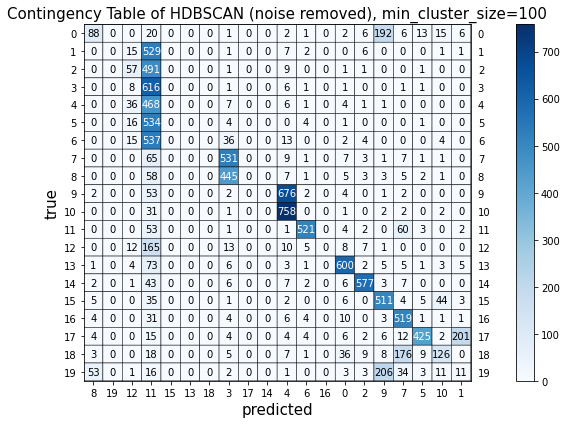

In [ ]:
#Contingency Matrix of HDBSCAN, noise removed (Best Model)
cm = confusion_matrix(predicted_labels_new, cluster_labels_new)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,6), xlabel='predicted', ylabel='true', title='Contingency Table of HDBSCAN (noise removed), min_cluster_size=100')

Approximately 13 clusters were created in HDBSCAN with 9 of them being major clusters. "-1" is the cluster label of the points that do not fall under the main clusters. Although the data points labeled as noise have been removed for the best model, the contingency matrix lacks the smoothness of the diagonalized contingency matrix created earlier by applying k-Means clustering on UMAP data. 

# Question 17

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


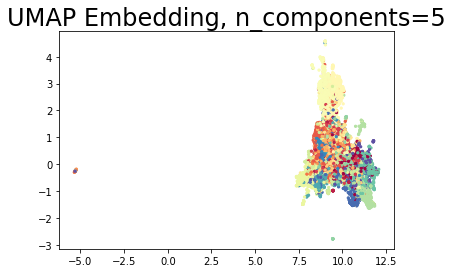

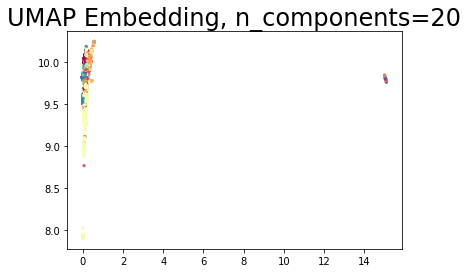

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


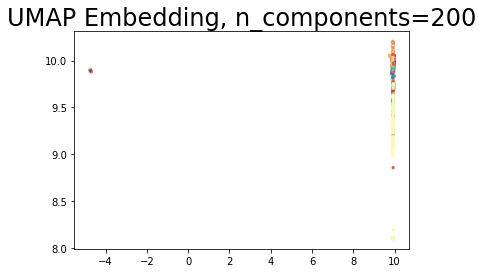

[0.30991663689219257, 0.0982048006382202, 0.08568625308577832, 0.3075492158267226, 0.11465978927950503, 0.09327638757247968, 0.3033879521637711, 0.08589556346009504, 0.038359243575845525]
['reduction= n_components=5 k=20', 'reduction= n_components=5 k=20', 'n_components=5 k=20', 'reduction= n_components=20 k=20', 'reduction= n_components=20 k=50', 'n_components=20 k=20', 'reduction= n_components=200 k=20', 'reduction= n_components=200 k=50', 'n_components=200 k=20']


In [ ]:
#Hyperparameter Tuning
n_components=[5,20,200]
k_values = [10,20,50]
cluster_values = [20]
eps_values=[0.5,5]
min_cluster_values = [100,200]
adjusted_rand_score_values=[]
highest_tracker_values=[]

for component in n_components:
  reduction_methods=(umap_reduction(data_all_tfidf, dataset_all.target, component, 'cosine'),TruncatedSVD(n_components=component, random_state=42).fit_transform(data_all_tfidf), NMF(n_components=component, init='random', random_state=0, max_iter=500).fit_transform(data_all_tfidf))
  for reduced_data in reduction_methods:
    adjusted_rand_score_highest=0
    highest_tracker=0
    for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=200).fit(reduced_data)
      if adjusted_rand_score(dataset_all.target, kmeans.labels_) > adjusted_rand_score_highest:
        adjusted_rand_score_highest=adjusted_rand_score(dataset_all.target, kmeans.labels_)
        highest_tracker="n_components="+str(component)+", k="+str(k)
      else:
        pass
    for n_clusters in cluster_values:
      model = AgglomerativeClustering(affinity='euclidean', n_clusters=n_clusters)
      model=model.fit(reduced_data)
      if adjusted_rand_score(dataset_all.target, model.labels_) > adjusted_rand_score_highest:
        adjusted_rand_score_highest=adjusted_rand_score(dataset_all.target, model.labels_)
        highest_tracker="n_components="+str(component)+", n_clusters="+str(n_clusters)
      else:
        pass
    for eps in eps_values:
      model_db = DBSCAN(eps=eps, min_samples=60).fit(reduced_data)
      cluster_label = model_db.labels_
      if adjusted_rand_score(dataset_all.target, model_db.labels_) > adjusted_rand_score_highest:
        adjusted_rand_score_highest=adjusted_rand_score(dataset_all.target, model_db.labels_)
        highest_tracker="n_components="+str(component)+", eps="+str(eps)
      else:
        pass
    for min_cluster in min_cluster_values:
      model_hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster)
      model_hdb.fit(reduced_data)
      if adjusted_rand_score(dataset_all.target, model_hdb.labels_) > adjusted_rand_score_highest:
        adjusted_rand_score_highest=adjusted_rand_score(dataset_all.target, model_hdb.labels_)
        highest_tracker="n_components="+str(component)+", min_cluster_size="+str(min_cluster)
      else:
        pass
    adjusted_rand_score_values.append(adjusted_rand_score_highest)
    highest_tracker_values.append(highest_tracker)

highest_adj_rand=list(zip(highest_tracker_values, adjusted_rand_score_values))
print("UMAP Reduced Data: ", highest_adj_rand[:3])
print("SVD Reduced Data: ", highest_adj_rand[3:6])
print("NMF Reduced Data: ", highest_adj_rand[6:9])

The adjusted rand scores for each of the clustering methods were computed for each type of the dimensionally reduced data, and the highest adjusted rand scores for each of the dimensionally reduced data were recorded.

**UMAP:**
*   n_components=5, Adjusted Rand Score: 0.30991663689219257, clustering: k-means, k=20

*   n_components=20, Adjusted Rand Score: 0.3075492158267226, clustering: k-means, k=20

*   n_components=200, Adjusted Rand Score: 0.3033879521637711, clustering: k-means, k=20

**SVD:** 
*   n_components=5, Adjusted Rand Score: 0.0982048006382202, clustering: k-means, k=20

*   n_components=20, Adjusted Rand Score: 0.11465978927950503, clustering: k-means, k=50

*   n_components=200, Adjusted Rand Score: 0.08589556346009504, clustering: k-means, k=50

**NMF:**
*   n_components=5, Adjusted Rand Score: 0.08568625308577832, clustering: k-means, k=20

*   n_components=20, Adjusted Rand Score: 0.09327638757247968, clustering: k-means, k=20

*   n_components=200, Adjusted Rand Score: 0.038359243575845525, clustering: k-means, k=20

*Overall, dimensional reduction by UMAP with n_components=5 and clustering by k-means with k=20 is shown to have the highest adjusted rand score of: 0.30991663689219257.*

# Question 18

Here, other clustering methods are investigated.

**OPTICS (Ordering Points To Identify the Clustering 
Structure)**

This method works similar to DBSCAN however, it covers for its weakness of missing meaningful clusters by ordering the points so that spatially close points become neighbors in the ordering.

In [ ]:
#OPTICS Clustering Method
from sklearn.cluster import OPTICS, cluster_optics_dbscan

min_samples_values=[45, 50, 55]
for min_samples in min_samples_values:
  model_clust = OPTICS(eps=0.5, min_samples=min_samples, cluster_method='dbscan', metric='euclidean')
  model_clust.fit(umap_reduced)
  print("\n Clustering Metrics for OPTICS (min_samples="+str(min_samples)+")")
  clustering_metrics(dataset_all.target, model_clust.labels_)


 Clustering Metrics for OPTICS (min_samples=45)
Homogeneity Score:  0.36344959261821275
Completeness Score:  0.5098003223115815
V_measure Score:  0.42436126541317587
Rand Score:  0.8248936296080052
Adjusted Rand Score:  0.17786198292594774
Adjusted Mutual Info Score:  0.4215621018845384

 Clustering Metrics for OPTICS (min_samples=50)
Homogeneity Score:  0.37572126549136575
Completeness Score:  0.5048428929098785
V_measure Score:  0.4308151968002098
Rand Score:  0.8391631862639882
Adjusted Rand Score:  0.1835003136411546
Adjusted Mutual Info Score:  0.4283783410386442

 Clustering Metrics for OPTICS (min_samples=55)
Homogeneity Score:  0.3693428022289645
Completeness Score:  0.5036767314269334
V_measure Score:  0.42617460029496407
Rand Score:  0.8367510531450865
Adjusted Rand Score:  0.17634616112065196
Adjusted Mutual Info Score:  0.42399544740995004


Adjusted Rand Index is observed at its highest (0.1835003136411546) when min_samples=50. Below is the observed contingency matrix.

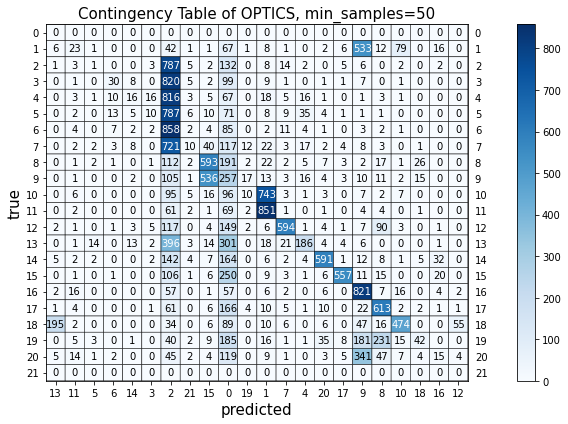

Computing Time: 122.41429615020752


In [ ]:
import timeit
from sklearn.cluster import OPTICS, cluster_optics_dbscan
start = time.time()


model_clust = OPTICS(eps=0.5, min_samples=50, cluster_method='dbscan', metric='euclidean')
model_clust.fit(umap_reduced)
cm = confusion_matrix(dataset_all.target, model_clust.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,6), xlabel='predicted', ylabel='true', title='Contingency Table of OPTICS, min_samples=50')

end = time.time()
print("Computing Time: "+str(end - start))

**BIRCH**

Birch is an alternative algorithm to MiniBatchKMeans, but is more memory efficient. It creates a Clustering Tree for specified data.

Homogeneity Score:  0.42877938803631793
Completeness Score:  0.46450175808487426
V_measure Score:  0.44592630313145504
Rand Score:  0.9221120921816005
Adjusted Rand Score:  0.3080960592930424
Adjusted Mutual Info Score:  0.44404519632825534


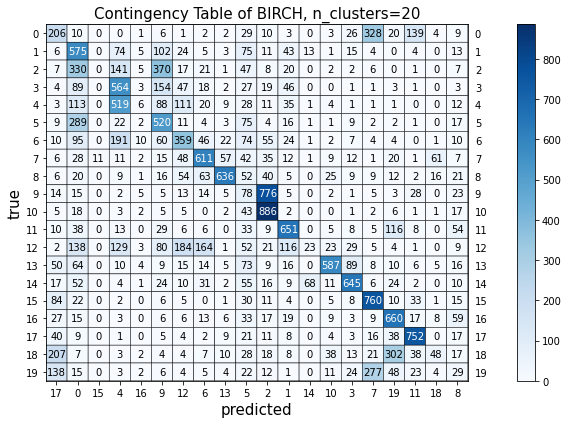

Computing Time: 4.58010721206665


In [ ]:
start = time.time()

model_birch = Birch(n_clusters=20)
model_birch.fit(umap_reduced)
cm = confusion_matrix(dataset_all.target, model_birch.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
clustering_metrics(dataset_all.target, model_birch.labels_)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,6), xlabel='predicted', ylabel='true', title='Contingency Table of BIRCH, n_clusters=20')

end = time.time()
print("Computing Time: "+str(end - start))

BIRCH and OPTICS both use euclidean distance/distance between the points for its metrics but the computing time for a single iteration is much faster with BIRCH as compared to OPTICS (4.58010721206665 [s] vs 122.41429615020752 [s]). The adjusted rand index is also much higher with BIRCH (0.3080960592930424 vs 0.1835003136411546). 

**Mini Batch K-Means**

K-Means updated for smaller batch sizes rather than the whole data, better than K-Means if the dataset is large.

Homogeneity Score:  0.444457604564184
Completeness Score:  0.46340988995960514
V_measure Score:  0.4537359270271818
Rand Score:  0.9253614929255675
Adjusted Rand Score:  0.2948513024051965
Adjusted Mutual Info Score:  0.45192515032380415


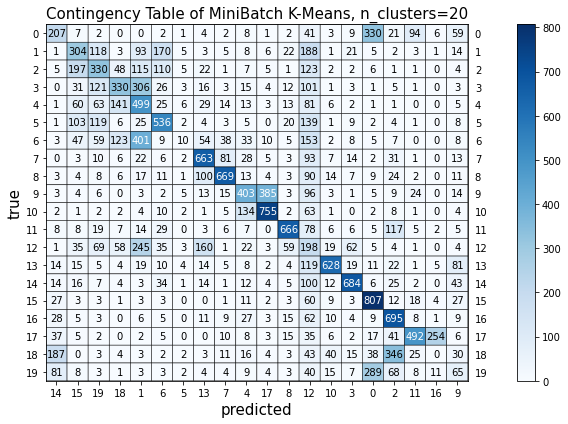

Computing Time: 4.775979042053223


In [ ]:
from sklearn.cluster import MiniBatchKMeans
start = time.time()

model_mini = MiniBatchKMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=200)
model_mini.fit(umap_reduced)
cm = confusion_matrix(dataset_all.target, model_mini.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
clustering_metrics(dataset_all.target, model_mini.labels_)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(8,6), xlabel='predicted', ylabel='true', title='Contingency Table of MiniBatch K-Means, n_clusters=20')

end = time.time()
print("Computing Time: "+str(end - start))

K-Means on UMAP reduced data using these same parameters has an adjusted rand index of 0.30991663689219257 as where this Mini Batch K-Means provides a score of 0.2948513024051965, creating little difference. However, the computing time is observed to be better with Mini Batch K-Means(4.775979042053223 [s] vs 74.41381978988647 [s]).

From the above, either BIRCH or Mini Batch K-Means may be a better method to enhance the clustering performance. 

# Question 19

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import umap

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


VGG network is trained by large amount of data, and has high accuracy on ImageNet. Therefore, it should have a great constructure about how to extract features of images. For any custom dataset, VGG still can get the suitable features. Hence, the performance will still be good.

# Question 20

First, we transform the image to (224, 224, 3) data. The class, FeatureExtractor, extracts the feature layers of the VGG, but we don't get all layers. Since we don't need the output of VGG, we get layers until the first part of fully-connected layer from VGG16. And the data would be transformed to (1, 1, 4096) in this layer. That's the reason that we have 4096 features.

# Question 21

In [ ]:
from PIL import Image
ans = 0
path = './flower_photos/'
for fl in ['daisy/', 'dandelion/', 'roses/', 'sunflowers/', 'tulips/']:
    for i in os.listdir(path+fl):
        im = Image.open(path+fl+i)
        ans += np.array(im).shape[0] * np.array(im).shape[1]
print('There are {} pixels in the original images.'.format(ans))

There are 382129582 pixels in the original images.


VGG extract 4096 features per image.

# Question 22

In [ ]:
print('number of 0 of features in text: {}'.format(np.sum(data_tfidf==0)))
print('number of 0 of features in image: {}'.format(np.sum(f_all==0)))

number of 0 of features in text: 184877742
number of 0 of features in image: 0


The extracted features of image are denser than features in text.

# Question 23

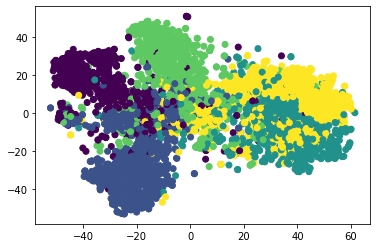

In [ ]:
from sklearn.manifold import TSNE
f_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(f_all)
plt.scatter(*f_tsne.T, c=y_all)
plt.show()

# Question 24

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [ ]:
np.random.seed(42)
random.seed(42)
#dimensionality reduction
f_svd = TruncatedSVD(n_components=50, random_state=42).fit_transform(f_all)
f_umap = umap.UMAP(n_components=50, random_state=42).fit_transform(f_all)
f_auto = Autoencoder(50).fit_transform(f_all)

In [ ]:
d = {0: 'None', 1: 'SVD', 2:'UMAP', 3:'Autoencoder'}
for i, f in enumerate([f_all, f_svd, f_umap, f_auto]):
    kmeans = KMeans(n_clusters=5, random_state=42).fit(f)
    print('DR: '+d[i]+', Clustering: Kmeans, rand_score = {}'.format(rand_score(kmeans.labels_, y_all)))
    clustering = AgglomerativeClustering(n_clusters=5).fit(f)
    print('DR: '+d[i]+', Clustering: Agglomerative, rand_score = {}'.format(rand_score(clustering.labels_, y_all)))
    hdbs = hdbscan.HDBSCAN(min_cluster_size=90,min_samples=20).fit(f)
    print('DR: '+d[i]+', Clustering: HDBSCAN, rand_score = {}'.format(rand_score(hdbs.labels_, y_all)))

DR: None, Clustering: Kmeans, rand_score = 0.704367025294035
DR: None, Clustering: Agglomerative, rand_score = 0.6862000871875192
DR: None, Clustering: HDBSCAN, rand_score = 0.20358404572368982
DR: SVD, Clustering: Kmeans, rand_score = 0.7029640043281845
DR: SVD, Clustering: Agglomerative, rand_score = 0.6780956582249245
DR: SVD, Clustering: HDBSCAN, rand_score = 0.20358404572368982
DR: UMAP, Clustering: Kmeans, rand_score = 0.7954023807985456
DR: UMAP, Clustering: Agglomerative, rand_score = 0.7875960529452524
DR: UMAP, Clustering: HDBSCAN, rand_score = 0.7894305555864994
DR: Autoencoder, Clustering: Kmeans, rand_score = 0.7047682067072006
DR: Autoencoder, Clustering: Agglomerative, rand_score = 0.7201393515001229
DR: Autoencoder, Clustering: HDBSCAN, rand_score = 0.20358404572368982


# Question 25

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 1280),
        nn.ReLU(True),
        nn.Linear(1280, 640),
        nn.ReLU(True), 
        nn.Linear(640, 5),
        nn.LogSoftmax(dim=1)
    )
    self.cuda()
    
    
  def forward(self, X):
    return self.model(X)
    
  def train(self, X, y):
    X = torch.tensor(X, dtype=torch.float32, device='cuda')
    y = torch.tensor(y, dtype=torch.int64, device='cuda')

    self.model.train()
        
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    for epoch in tqdm(range(100)):
      for (X_, y_) in dataloader:
        optimizer.zero_grad()
        X_, y_ = X_.to('cuda'), y_.to('cuda')
        pred = self.forward(X_)
        loss = criterion(pred, y_)
        loss.backward()
        optimizer.step()
    return self
    
  def eval(self, X_test, y_test):
    X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
    y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
    self.model.eval()
    X_test, y_test = X_test.to('cuda'), y_test.to('cuda')
    pred = self.forward(X_test)
    pred = torch.argmax(pred, dim=1)
    acc = 0
    for i in range(pred.size()[0]):
      if pred[i] == y_test[i]:
        acc += 1
    print('accuracy: {}'.format(acc/pred.size()[0]))

In [ ]:
#original features
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)
mlp = MLP(num_features)
mlp.train(X_train, y_train)

In [ ]:
mlp.eval(X_test, y_test)

accuracy: 0.9087193460490464


In [ ]:
#dimennsional reduction features by umap
X_train, X_test, y_train, y_test = train_test_split(f_umap, y_all, test_size=0.2, random_state=42)
mlp = MLP(50)
mlp.train(X_train, y_train)

In [ ]:
mlp.eval(X_test, y_test)

accuracy: 0.8474114441416893


The accuracy of the MLP classifier on the original VGG features is about 90.8%(4096 features), and 84.7%(50 features) for the data after dimensinality reduction by UMAP. We can see there is about 6.1% difference after we reduct the dimension.

We choose our best model (umap, kmeans) to see our accuracy.

In [ ]:
def plt_contingency_matrix(pred_test, txt):
  cmx_data = confusion_matrix(y_all, pred_test)
  df_cmx = pd.DataFrame(cmx_data)
  sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
  plt.title('Contingency Matrix for '+txt)
  plt.xlabel('Predicted Category')
  plt.ylabel('True Category')
  plt.show()

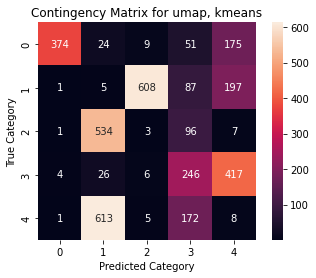

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(f_umap)
plt_contingency_matrix(kmeans.labels_,'umap, kmeans')

By the contingency matrix, our accuracy is (374+613+608+96+417)/3670=0.5743

The performance is better of the MLP classifier compared to our best unsupervised model(UMAP, kmeans). Since MLP classifier is supervised learning, knowing exactly every label in the training data. On the contrary, unsupervised models group only have information about features and try to group them.